# PyTorch Workflow

Let's explore an example PyTorch end-to-end workflow.

Resources:
* Book version - https://www.learnpytorch.io/01_pytorch_workflow/

In [560]:
what_were_covering = {1: "Data (prepare and load)",
                      2: "build model",
                      3: "fitting a model to the data",
                      4: "making predictions and evaluating a model (inference)",
                      5: "saving and loading a model",
                      6: "putting it all together"}
what_were_covering

{1: 'Data (prepare and load)',
 2: 'build model',
 3: 'fitting a model to the data',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [561]:
import torch
if torch.cuda.is_available():
    print("GPU is available")
    print("GPU Device Name:", torch.cuda.get_device_name(0))
else:
    print("GPU not available, using CPU")

GPU is available
GPU Device Name: NVIDIA GeForce RTX 3070 Ti


In [562]:
from torch import nn # nn contains all of PyTorch's building blocks for neural networks -https://pytorch.org/docs/stable/nn.html
import matplotlib.pyplot as plt

In [563]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [564]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [565]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

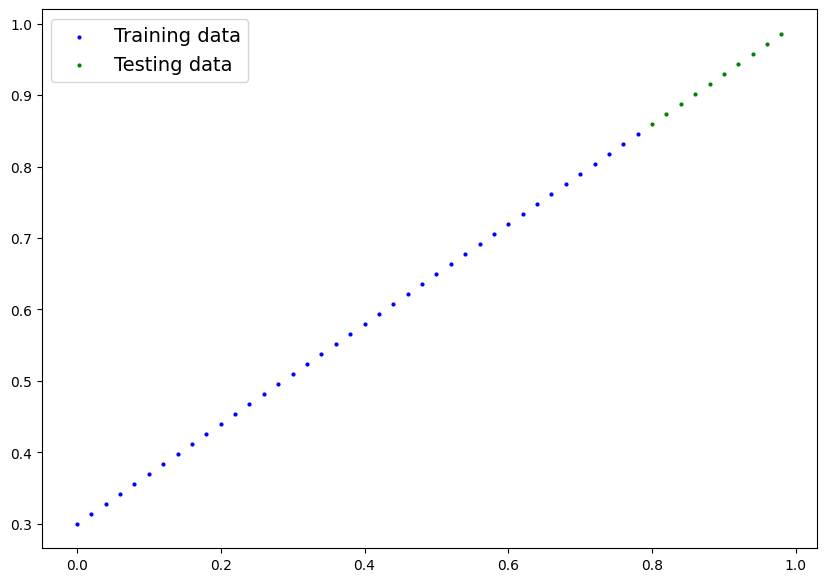

In [566]:
plot_predictions();

Because we are building classes we uses OOP: https://realpython.com/python3-object-oriented-programming

We use two main alogorithms for our model:
- gradient descent - https://www.youtube.com/watch?v=IHZwWFHWa-w
- backpropagation - https://www.youtube.com/watch?v=Ilg3gGewQ5U&t

In [567]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [568]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [569]:
model_0.weights

Parameter containing:
tensor([0.3367], requires_grad=True)

In [570]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [571]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [572]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


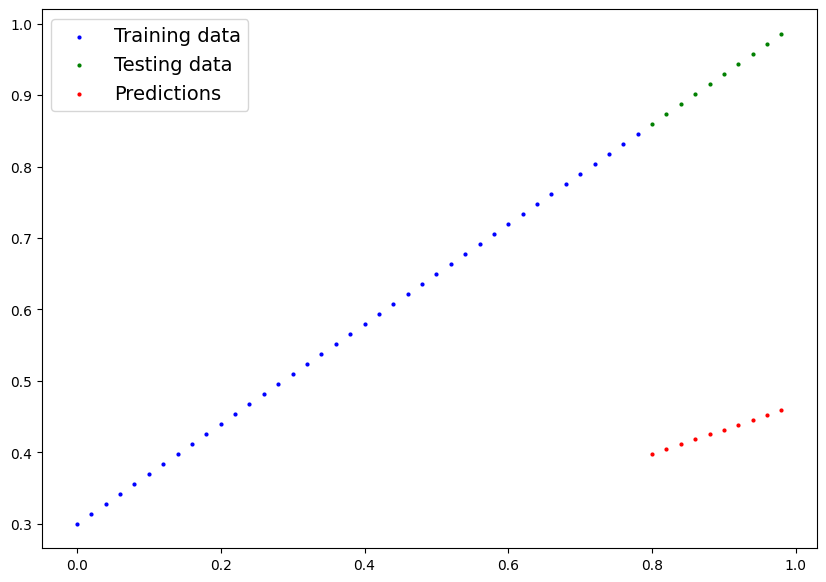

In [573]:
plot_predictions(predictions=y_preds)

In [574]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

### 3. Train model 

The whole idea of training is to move from a poor representation of a model to a better representation of the data.

One way to measure how wrong are our data is to use the loss function.

* Note: Loss function may also be called cost function or criterion in different areas. 
        For our we are going to refer to it as a loss function.

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (e.g weight and bias) to improve the loss function - https://pytorch.org/docs/stable/optim.html

And specifically for PyTorch, we need:
* A training loop 
* A testing loop

In [575]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # The larger the learning rate is the larger the changes in the parameters is

For a regression problem, a loss function of `nn.L1Loss()` and an optimizer like `torch.optim.SGD()` will suffice whereas for a classification problem, you'll likely use a loss function of `nn.BCELoss()` (binary cross entropy loss).

### Building a training loop (and a testing loop) in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves moving through our model's `forward()` 
   functions) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground thruth label)
3. Optimizer zero grad
4. Loss backward - move backwards through the network to calculate the gradients 
   of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve
   the loss (**gradient descent**)

In [576]:
with torch.inference_mode():
    list(model_0.parameters())

In [577]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [578]:
epochs = 185
list_loss = []
### Training
# 0. Loop through the data
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # train mode in PyTorch sets all parameters that require gradients to require gradients
    dict_loss = {}
    # 1. Forward pass
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)
    print(f"Loss: {loss}")

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to the parameters of the model
    loss.backward()
    print(model_0.state_dict())
    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # by default how the optimizer changes will accumulate through the loop so... we have to zero them above in step 3 for the next iteration of the loop
    print(model_0.state_dict())

    if epoch == 165:
        optimizer.param_groups[0]['lr'] /=4

    # Testing
    model_0.eval() # turns off gradient tracking and other needless stettings for evaluation/testing (dropout/batch)
    with torch.inference_mode(): # Turns off gradient tracking and a couple of more things - https://twitter.com/PyTorch/status/1437838231505096708
        # 1. Do the forward pass 
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss:{test_loss}")

    # Make a dictionnary of the values and add it to a list for each epoch
    dict_loss["epoch"] = epoch
    dict_loss["train loss"] = round(loss.item(), 4)
    dict_loss["test loss"] = round(test_loss.item(),4)
    dict_loss["weights"] = round(model_0.weights[0].item(),4)
    dict_loss["bias"] = round(model_0.bias[0].item(),4)

    list_loss.append(dict_loss)

    print(f"=============================================================================================")
        

Loss: 0.31288138031959534
OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 0 | Loss: 0.31288138031959534 | Test loss:0.48106518387794495
Loss: 0.3013603389263153
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
Loss: 0.28983935713768005
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
OrderedDict([('weights', tensor([0.3484])), ('bias', tensor([0.1588]))])
Loss: 0.2783183455467224
OrderedDict([('weights', tensor([0.3484])), ('bias', tensor([0.1588]))])
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
Loss: 0.26679736375808716
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
OrderedDict([('weights', tensor([0.3562])), ('bias', tensor([0.1788]))])
Loss: 0.2552763521671295
OrderedDict([('weights', tensor([0.3562])), ('bi

In [579]:
test_loss = []
for dict_loss in list_loss:
    test_loss.append(dict_loss["test loss"])
train_loss = []
for dict_loss in list_loss:
    train_loss.append(dict_loss["train loss"])
epoch = torch.arange(1,186,1)

In [580]:
# Plot the loss curves
def plot_loss(epoch, train_loss, test_loss):
    '''
    Plot the test loss along with the epoch
    '''
    plt.figure(figsize=(10,7))
    plt.plot(epoch, train_loss, label="train loss")
    plt.plot(epoch, test_loss, label="test loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train and test loss curves")
    plt.legend(prop={"size":14})

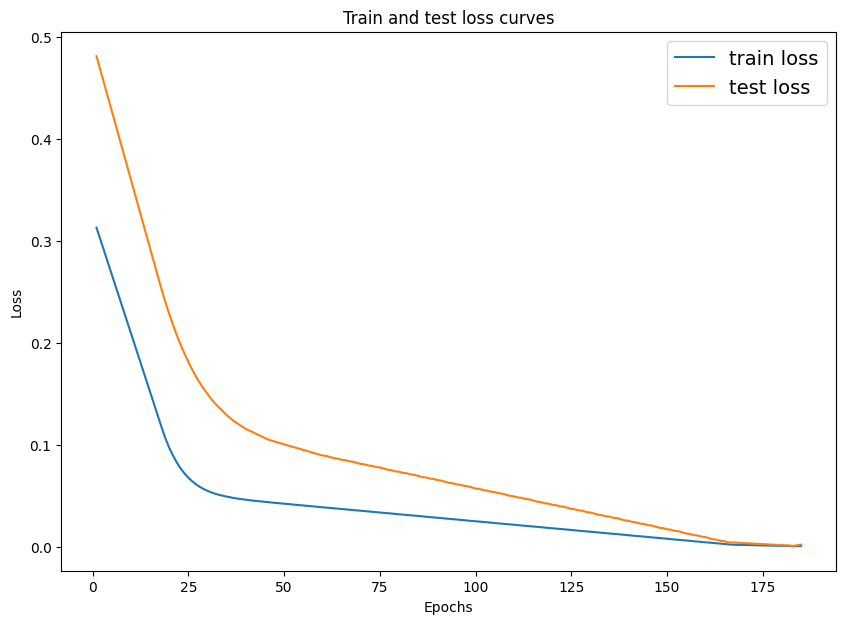

In [581]:
plot_loss(epoch, train_loss, test_loss)

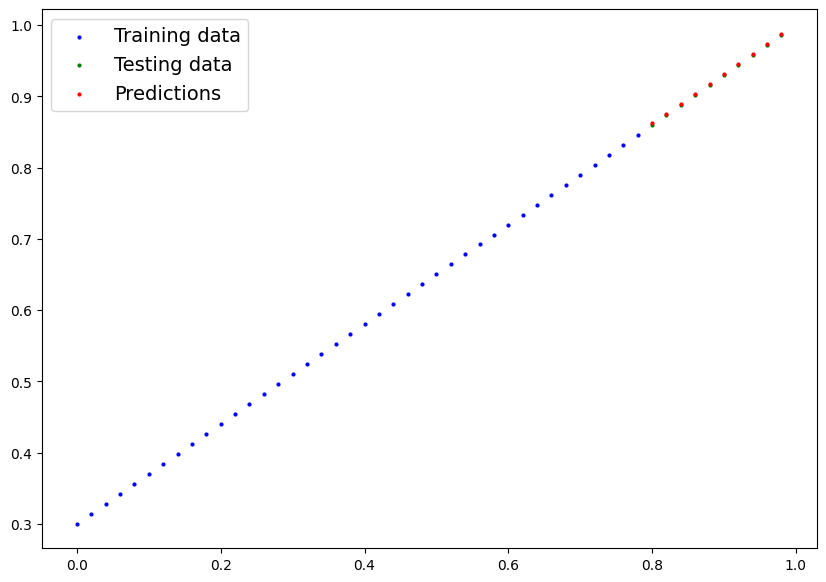

In [582]:
with torch.inference_mode(): 
    test_preds = model_0(X_test)
plot_predictions(predictions=test_preds)

In [583]:
weight, bias

(0.7, 0.3)

In [584]:
list_loss

[{'epoch': 0,
  'train loss': 0.3129,
  'test loss': 0.4811,
  'weights': 0.3406,
  'bias': 0.1388},
 {'epoch': 1,
  'train loss': 0.3014,
  'test loss': 0.4676,
  'weights': 0.3445,
  'bias': 0.1488},
 {'epoch': 2,
  'train loss': 0.2898,
  'test loss': 0.4541,
  'weights': 0.3484,
  'bias': 0.1588},
 {'epoch': 3,
  'train loss': 0.2783,
  'test loss': 0.4407,
  'weights': 0.3523,
  'bias': 0.1688},
 {'epoch': 4,
  'train loss': 0.2668,
  'test loss': 0.4272,
  'weights': 0.3562,
  'bias': 0.1788},
 {'epoch': 5,
  'train loss': 0.2553,
  'test loss': 0.4137,
  'weights': 0.3601,
  'bias': 0.1888},
 {'epoch': 6,
  'train loss': 0.2438,
  'test loss': 0.4002,
  'weights': 0.364,
  'bias': 0.1988},
 {'epoch': 7,
  'train loss': 0.2322,
  'test loss': 0.3868,
  'weights': 0.3679,
  'bias': 0.2088},
 {'epoch': 8,
  'train loss': 0.2207,
  'test loss': 0.3733,
  'weights': 0.3718,
  'bias': 0.2188},
 {'epoch': 9,
  'train loss': 0.2092,
  'test loss': 0.3598,
  'weights': 0.3757,
  'bias': 

## Saving a model in PyTorch
There are three main methods you should know about to save and load a model in PyTorch

1. `torch.save()` - allows you save a PyTorch object in Python's pickle format
2. `torch.load()` - allows you to load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - allows you to load a model's saved state dictionary

PyTorch save and load code tutorial + extra-curriculum - https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [585]:
# Create a function to save a model
def save_model(model_name, model):
    # Saving our PyTorch model
    from pathlib import Path

    # 1. Create models directory
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

    # 2. Create model save path
    MODEL_NAME = model_name
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

    # 3. Save the model state dict
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(),
            f=MODEL_SAVE_PATH)

In [586]:
# Save model 0
save_model("01_pytorch_workflow_model_0.pth", model_0)

Saving model to: models\01_pytorch_workflow_model_0.pth


## Loading our PyTorch model

Since we saved our model's state dict rather than the entire model, we'll create a new instance
of our model class and load the saved `state_dict()` into that.

In [587]:
# Create a function to load a model
def load_model(model_name, model_class):
    # To load in a save state_dict(), we have to instantiate a new instance of our model class
    loaded_model = model_class

    # Load the saved state_dict() of model_0 (this will update the new instance with updated parameters)
    from pathlib import Path
    MODEL_PATH = Path("models")
    MODEL_NAME = model_name
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

    # Evaluate the loaded model
    loaded_model.state_dict()

    # Return the model
    return loaded_model

In [588]:
# Load model 0 
loaded_model_0 = load_model("01_pytorch_workflow_model_0.pth", LinearRegressionModel())

In [589]:
# Make some predictions
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8618],
        [0.8758],
        [0.8898],
        [0.9038],
        [0.9178],
        [0.9318],
        [0.9458],
        [0.9598],
        [0.9738],
        [0.9878]])

In [590]:
# Compare loaded model preds with original model preds
test_pred == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### 6. Putting all together

Let's go back through the steps above and see it all in one place.

### 6.2 Building a PyTorch Linear model

In [591]:
# Create a linear model by subclassing nn.Module
class LinearModelRegressionV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters / also called: linear transform, probing layer, fully connected layer, dense layer
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.linear_layer(x)
    
# Set the manual seed
torch.manual_seed(42)
model_1 = LinearModelRegressionV2()
model_1, model_1.state_dict()

(LinearModelRegressionV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

### 6.3 Training code

For training we need:
* Loss function
* Optimizer
* Training Loop
* Testing Loop


In [592]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01)

In [593]:
# Let's write a training loop
torch.manual_seed(42)
list_loss = []
epochs = 140

for epoch in range(epochs):
    model_1.train()
    dict_loss = {}

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform backpropagation
    loss.backward()
    print(f"Epoch: {epoch} ", model_1.state_dict())

    # 5. Optimizer Step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

    # Reducing the learning rate
    
    if epoch == 110:
        optimizer.param_groups[0]['lr'] /=4

    # Print out what's happening

    if epoch % 10 == 0:
        print(f"Train loss: {loss} | Test loss: {test_loss} ")

    # Make a dictionnary of the values and add it to a list for each epoch
    dict_loss["epoch"] = epoch
    dict_loss["train loss"] = round(loss.item(), 4)
    dict_loss["test loss"] = round(test_loss.item(),4)
    dict_loss["weights"] = round(model_0.weights[0].item(),4)
    dict_loss["bias"] = round(model_0.bias[0].item(),4)

    list_loss.append(dict_loss)
    print(f"=========================================================================================================")


Epoch: 0  OrderedDict([('linear_layer.weight', tensor([[0.7645]])), ('linear_layer.bias', tensor([0.8300]))])
Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089 
Epoch: 1  OrderedDict([('linear_layer.weight', tensor([[0.7606]])), ('linear_layer.bias', tensor([0.8200]))])
Epoch: 2  OrderedDict([('linear_layer.weight', tensor([[0.7567]])), ('linear_layer.bias', tensor([0.8100]))])
Epoch: 3  OrderedDict([('linear_layer.weight', tensor([[0.7528]])), ('linear_layer.bias', tensor([0.8000]))])
Epoch: 4  OrderedDict([('linear_layer.weight', tensor([[0.7489]])), ('linear_layer.bias', tensor([0.7900]))])
Epoch: 5  OrderedDict([('linear_layer.weight', tensor([[0.7450]])), ('linear_layer.bias', tensor([0.7800]))])
Epoch: 6  OrderedDict([('linear_layer.weight', tensor([[0.7411]])), ('linear_layer.bias', tensor([0.7700]))])
Epoch: 7  OrderedDict([('linear_layer.weight', tensor([[0.7372]])), ('linear_layer.bias', tensor([0.7600]))])
Epoch: 8  OrderedDict([('linear_layer.weight', tensor([[

In [594]:
test_loss = []
for dict_loss in list_loss:
    test_loss.append(dict_loss["test loss"])
train_loss = []
for dict_loss in list_loss:
    train_loss.append(dict_loss["train loss"])
epoch = torch.arange(1,141,1)

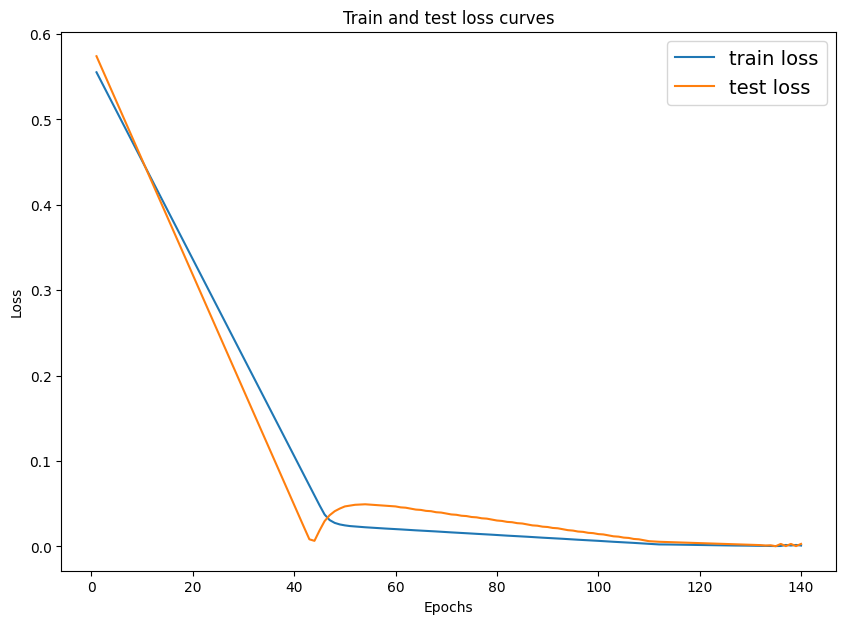

In [595]:
# Plot loss curves
plot_loss(epoch, train_loss, test_loss)

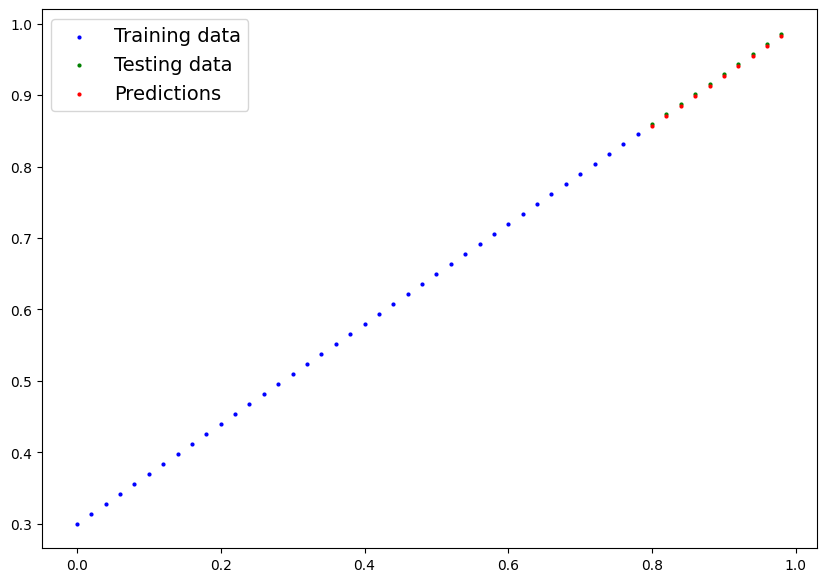

In [596]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data and plot it
with torch.inference_mode(): 
    test_preds = model_1(X_test)
plot_predictions(predictions=test_preds)

### 6.5 Saving and loading a trained model


In [597]:
# Save model 1
save_model("01_pytorch_workflow_model_1.pth", model_1)

Saving model to: models\01_pytorch_workflow_model_1.pth


In [598]:
# Load model 1
loaded_model_1 = load_model("01_pytorch_workflow_model_1.pth", LinearModelRegressionV2())

In [599]:
# Make some predictions
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_1(X_test)
loaded_model_preds == test_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [600]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6976]])),
             ('linear_layer.bias', tensor([0.2991]))])

In [601]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6976]])),
             ('linear_layer.bias', tensor([0.2991]))])